In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
#from numpy import random
#np.random.seed(42) # Set seed for reproducibility

from scipy.stats import kstest, probplot, gamma, chi2
from scipy.linalg import sqrtm

from scipy.special import erfcinv
import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

In [2]:
def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM

def Q_DM(diff_mean_1, cov_1, n_samples):
    
    # Sampling
    r_tot = np.dot(sqrtm(np.linalg.inv(cov_1)), np.random.multivariate_normal(0*diff_mean_1, cov_1, size=n_samples).T)  # Shape: (d, n_samples)
    Q = np.zeros(n_samples)  # Initialize W
    for i in range(n_samples):
        Q[i] = np.dot(r_tot[:, i], r_tot[:, i])  # Shape: (n_samples,)
    return Q


#def Q_tot(diff_mean_1, diff_mean_2, diff_mean_3, cov_1, cov_2, cov_3, n_samples, L):
def Q_tot(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, L, H0=False):
    cov_1 = cov_A + cov_B
    cov_2 = cov_A + cov_C
    cov_3 = cov_B + cov_C

    DA = np.random.multivariate_normal(mean_A, cov_A, size=n_samples)
    DB = np.random.multivariate_normal(mean_B, cov_B, size=n_samples)
    DC = np.random.multivariate_normal(mean_C, cov_C, size=n_samples)
    

    # Sampling
    X = np.dot(sqrtm(np.linalg.inv(cov_1)), np.array(DA-DB).T)  # Shape: (d, n_samples)
    Y = np.dot(sqrtm(np.linalg.inv(cov_2)), np.array(DA-DC).T)  # Shape: (d, n_samples)
    Z = np.dot(sqrtm(np.linalg.inv(cov_3)), np.array(DB-DC).T)  # Shape: (d, n_samples)

    if H0==True:
        r_tot = (X - np.mean(X, axis=1, keepdims=True)) + \
                (Y - np.mean(Y, axis=1, keepdims=True)) + \
                (Z - np.mean(Z, axis=1, keepdims=True))
    else:
        r_tot = X + Y + Z
    Q = np.zeros(n_samples)  # Initialize W
    for i in range(n_samples):
        Q[i] = np.dot(r_tot[:, i], r_tot[:, i])  # Shape: (n_samples,)

    return Q / L**2



# Dataset A

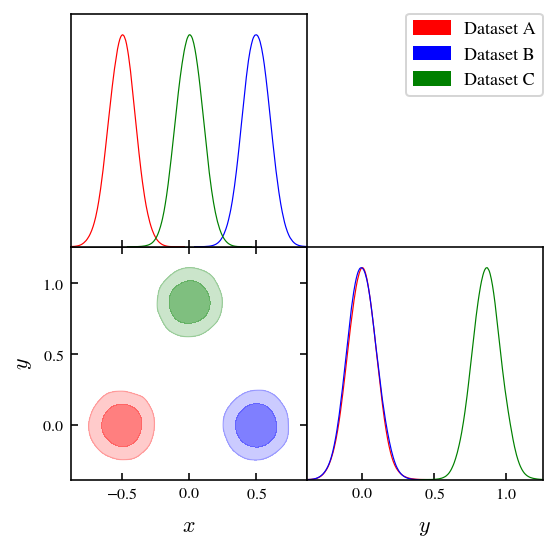

In [3]:
# Fixed constants

# Parameters
d = 2 # Dimension of shared parameter space
N = 3 # Num of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e6)  # Number of samples


mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)




# $\tilde{Q} \sim \Gamma(d/2, 2/L)$?

In [4]:
# Fixed constants
# Parameters
d = 2 # Dimension of shared parameter space
N = 3 # Num of datasets
L = N*(N-1)/2  # Number of tension vectors


n_samples = int(5e7)  # Number of samples

cov_1 = cov_A + cov_B
cov_2 = cov_A + cov_C
cov_3 = cov_B + cov_C
diff_mean_1 = mean_A - mean_B
diff_mean_2 = mean_A - mean_C
diff_mean_3 = mean_B - mean_C

r_1 = np.dot(sqrtm(np.linalg.inv(cov_1)), diff_mean_1)
r_2 = np.dot(sqrtm(np.linalg.inv(cov_2)), diff_mean_2)
r_3 = np.dot(sqrtm(np.linalg.inv(cov_3)), diff_mean_3)

# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)

t=np.linspace(0, 1.1*np.linalg.norm(R_CM)**2, 100)
theoretical_dist = gamma.pdf(t,a=d/2, scale=2/L)
#sample_dist = Q_tot(diff_mean_1, diff_mean_2, diff_mean_3, cov_1, cov_2, cov_3, n_samples, L)
sample_dist_H0 = Q_tot(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, L, H0=True)
sample_dist_H1 = Q_tot(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, L, H0=False)


In [5]:
from scipy.integrate import quad

# Integrate from np.linalg.norm(R_CM)**2 to infinity
PTE = np.sum(sample_dist_H0[sample_dist_H0 >= np.linalg.norm(R_CM)**2])/ len(sample_dist_H0)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'n_sigma = {n_sigma:.2f}')

n_sigma = inf


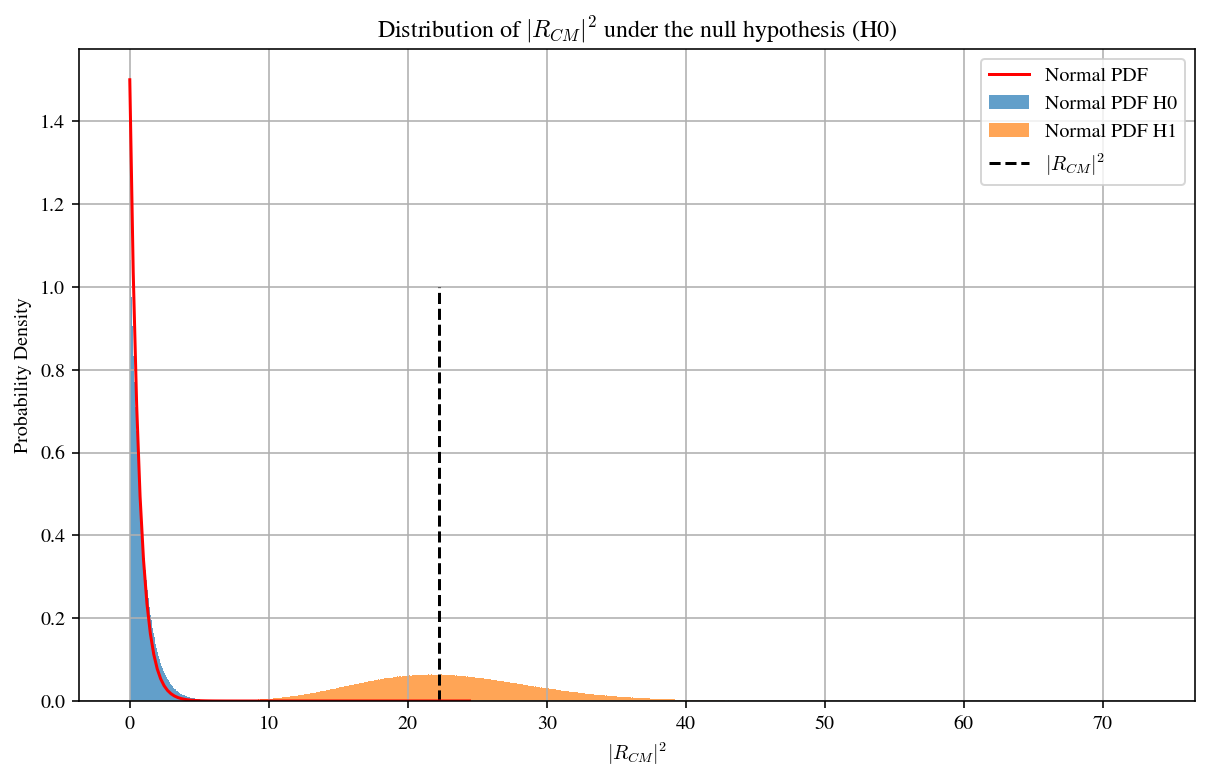

In [6]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(sample_dist_H0, label='Normal PDF H0', density=True, 
         bins=int(np.sqrt(len(sample_dist_H0))), alpha=0.7)
plt.hist(sample_dist_H1, label='Normal PDF H1', density=True, 
         bins=int(np.sqrt(len(sample_dist_H1))), alpha=0.7)
plt.plot(t, theoretical_dist, color='red', label='Normal PDF')
plt.vlines(np.linalg.norm(R_CM)**2, 0, 1, color='black', linestyle='--', label='$|R_{CM}|^2$')
plt.title('Distribution of $|R_{CM}|^2$ under the null hypothesis (H0)')
plt.xlabel('$|R_{CM}|^2$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
n_samples = int(1e3)  # Number of samples
cov_1 = cov_A + cov_B
cov_2 = cov_A + cov_C
cov_3 = cov_B + cov_C

DA = np.random.multivariate_normal(mean_A, cov_A, size=n_samples)
DB = np.random.multivariate_normal(mean_B, cov_B, size=n_samples)
DC = np.random.multivariate_normal(mean_C, cov_C, size=n_samples)


# Sampling
X = np.dot(sqrtm(np.linalg.inv(cov_1)), np.array(DA-DB).T)  # Shape: (d, n_samples)
Y = np.dot(sqrtm(np.linalg.inv(cov_2)), np.array(DA-DC).T)  # Shape: (d, n_samples)
Z = np.dot(sqrtm(np.linalg.inv(cov_3)), np.array(DB-DC).T)  # Shape: (d, n_samples)

In [8]:
X_H0 = X - np.mean(X, axis=1, keepdims=True)
Y_H0 = Y - np.mean(Y, axis=1, keepdims=True)
Z_H0 = Z - np.mean(Z, axis=1, keepdims=True)

In [9]:
np.mean(X_H0, axis=1), np.mean(Y_H0, axis=1), np.mean(Z_H0, axis=1)

(array([-1.19726451e-15,  0.00000000e+00]),
 array([ 1.59872116e-16, -4.26325641e-17]),
 array([4.70734562e-17, 1.49213975e-16]))

In [10]:
print(np.mean(X, axis=1), np.mean(Y, axis=1), np.mean(Z, axis=1))
print('\n')
print(np.mean(X_H0, axis=1), np.mean(Y_H0, axis=1), np.mean(Z_H0, axis=1))

[-7.10801666  0.01917204] [-3.59547541 -6.13614082] [ 3.51254124 -6.15531286]


[-1.19726451e-15  0.00000000e+00] [ 1.59872116e-16 -4.26325641e-17] [4.70734562e-17 1.49213975e-16]


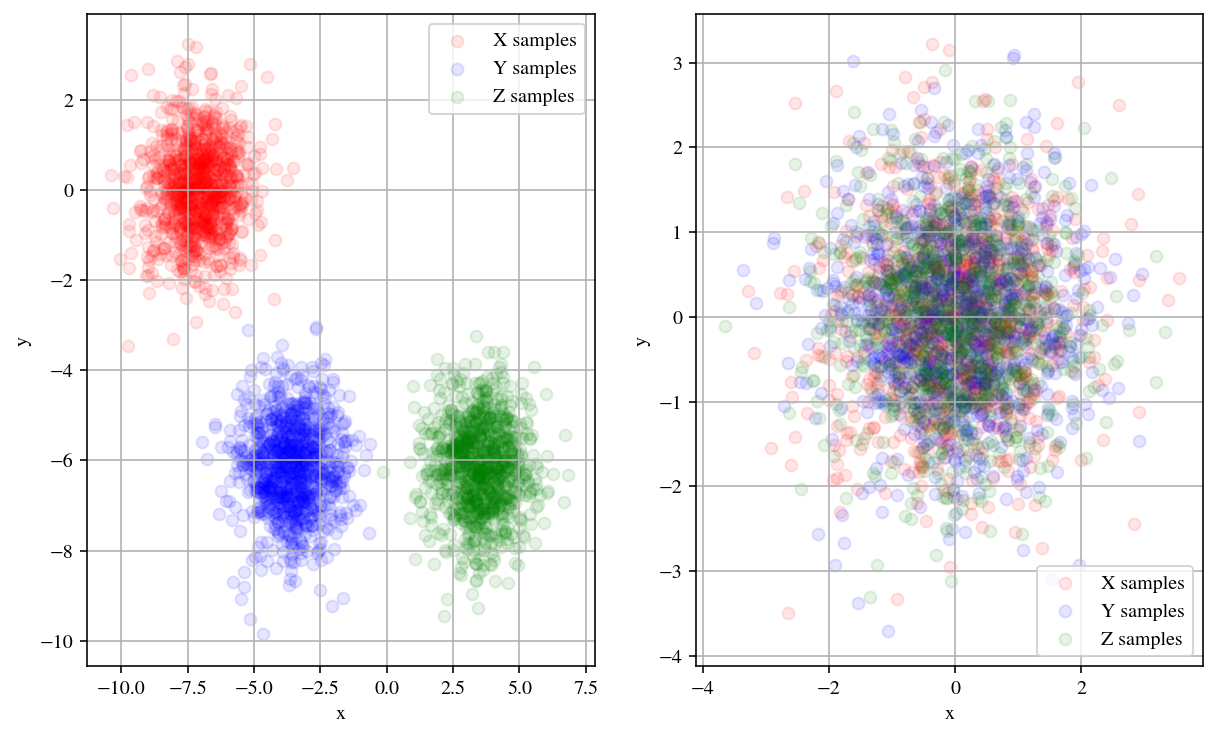

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))



ax[1].scatter(X_H0[0], X_H0[1], color='red', alpha=0.1, label='X samples')
ax[1].scatter(Y_H0[0], Y_H0[1], color='blue', alpha=0.1, label='Y samples')
ax[1].scatter(Z_H0[0], Z_H0[1], color='green', alpha=0.1, label='Z samples')

ax[0].scatter(X[0], X[1], color='red', alpha=0.1, label='X samples')
ax[0].scatter(Y[0], Y[1], color='blue', alpha=0.1, label='Y samples')
ax[0].scatter(Z[0], Z[1], color='green', alpha=0.1, label='Z samples')

for ax_i in ax:
    ax_i.set_xlabel('x')
    ax_i.set_ylabel('y')
    #ax_i.set_xlim(-1.5, 1.5)
    #ax_i.set_ylim(-1.5, 1.5)
    ax_i.grid(True)
    ax_i.legend()

In [12]:
N_sigma = np.zeros(5000)
# Calculate N_sigma for each sample in sample_dist_H1
#for i in range(len(sample_dist_H1)):
for i in range(5000):
    Q = sample_dist_H1[i]
    PTE = np.sum(sample_dist_H0[sample_dist_H0 >= Q])/ len(sample_dist_H0)
    N_sigma[i] = np.sqrt(2)*erfcinv(PTE)

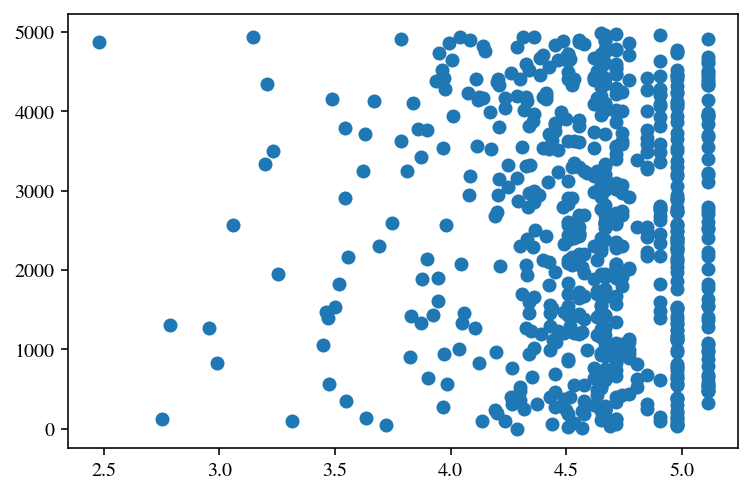

In [13]:
plt.plot(N_sigma, np.arange(len(N_sigma)), marker='o', linestyle='None')

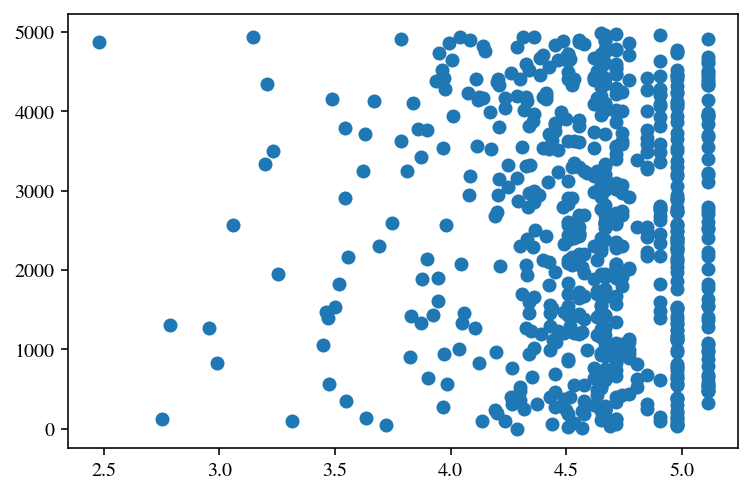

In [14]:
N_sigma_1 = N_sigma[N_sigma > 0]

plt.plot(N_sigma_1, np.arange(len(N_sigma_1)), marker='o', linestyle='None')

In [15]:
N_sigma_2 = N_sigma_1[np.isfinite(N_sigma_1)]
print(N_sigma_2)

[4.28583453 4.56600487 4.50685927 4.68913537 4.97900757 4.97900757
 4.97900757 3.72172499 4.97900757 4.71205617 4.43625147 4.53423788
 4.13486699 3.31466415 4.90237479 4.97900757 4.23449061 4.64999779
 4.71205617 4.71205617 2.75100633 4.97900757 3.63586474 4.90237479
 4.66844288 4.97900757 4.50685927 4.57780005 4.97900757 4.19866429
 4.56600487 4.64999779 4.97900757 4.18915597 4.66844288 4.4986308
 4.66844288 4.31699842 4.84749034 4.66844288 4.66844288 4.66844288
 3.96732592 4.44854657 4.66844288 4.97900757 4.61793821 4.37479145
 4.26648025 4.84749034 5.10992265 4.71205617 3.54568469 4.57780005
 4.29777347 4.49071177 4.97900757 4.97900757 4.97900757 4.43035324
 4.51557661 4.71205617 4.2612449  4.73842569 4.63329387 4.76878006
 4.44854657 4.29777347 5.10992265 5.10992265 5.10992265 4.63329387
 4.64999779 4.29777347 4.80440709 4.64999779 5.10992265 5.10992265
 5.10992265 4.57780005 4.97900757 4.53423788 4.97900757 3.98173014
 3.47201152 4.97900757 5.10992265 4.66844288 4.90237479 4.80440

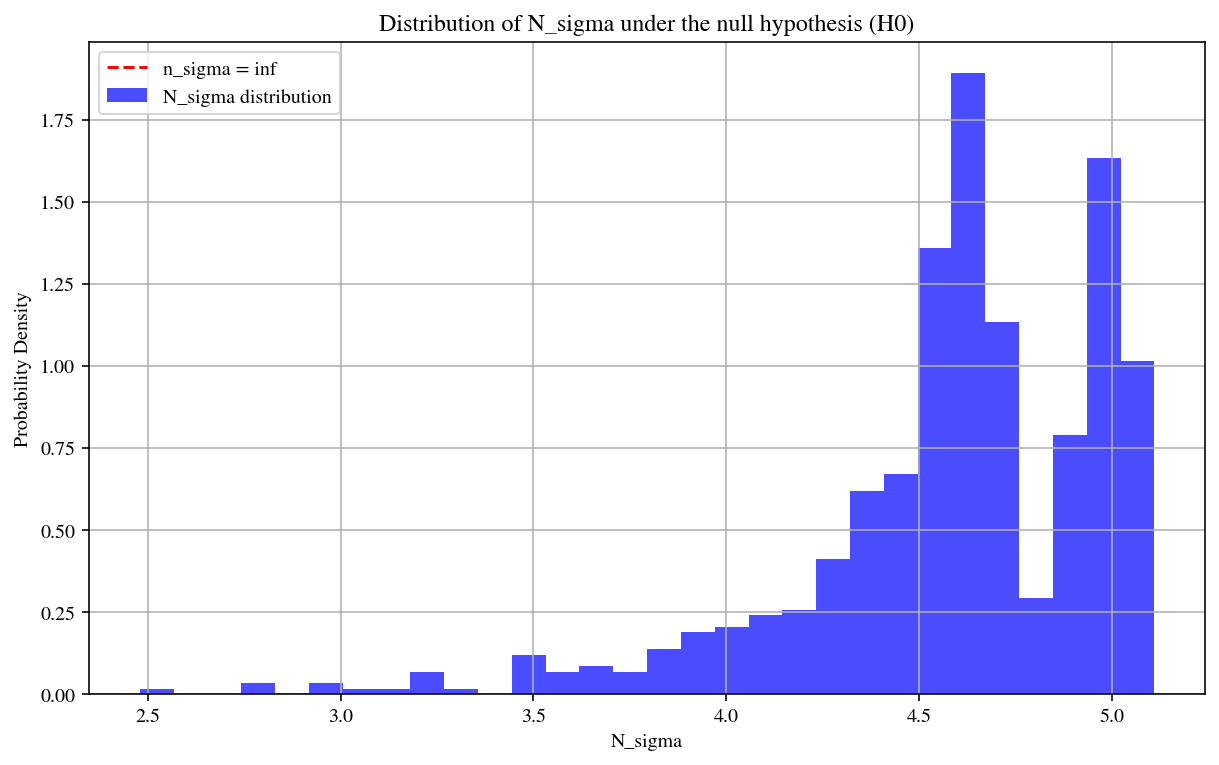

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(N_sigma_2, bins=30, density=True, alpha=0.7, color='blue', label='N_sigma distribution')
ax.axvline(n_sigma, color='red', linestyle='--', label=f'n_sigma = {n_sigma:.2f}')
ax.set_xlabel('N_sigma')
ax.set_ylabel('Probability Density')
ax.set_title('Distribution of N_sigma under the null hypothesis (H0)')
ax.grid(True)
ax.legend()
plt.show()